In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import pickle
import pandas as pd
from suicide_data import SuicideDataset
from torch.utils.data import  DataLoader
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from utils import sketch,precision_recall_f1,accuracy_cal,map_to_labels
import copy
from model.attention_bilstm import BiLSTM_Attention
from model.lstm import SentimentLSTM
from model.rnn import SentimentRNN
from model.gru import GRU
from model.cnn import CNN

Load configuration,data,pretrained embeddings


In [2]:
# Load configuration file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    lstm_config = config['LSTM']
    bilstm_config = config['BiLSTM_Attention']
    rnn_config = config['RNN']
    gru_config = config['GRU']
    cnn_config = config['CNN']

In [3]:
#Load training data
train_df = pd.read_csv("data/train_data.csv")
#Load validation data
val_df = pd.read_csv("data/val_data.csv")
#Load tokenizer object
with open("embeddings/tokenizer.json", "r") as f:
    tokenizer_json = json.load(f)
    tokenizer = tokenizer_from_json(tokenizer_json)
with open("embeddings/CBOW_embeddings.pkl" , "rb") as cbow:
    cbow_embeddings = pickle.load(cbow)
with open("embeddings/SkipGram_embeddings.pkl" , "rb") as sg:
    sg_embeddings = pickle.load(sg)

In [4]:
trainset = SuicideDataset(texts = train_df["cleaned_text"], labels = train_df["class"], tokenizer = tokenizer)
valset = SuicideDataset(val_df["cleaned_text"], val_df["class"], tokenizer)
train_loader = DataLoader(trainset, batch_size= 64,shuffle=True,drop_last=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=True, drop_last=True)

In [5]:
VOCAB_SIZE=len(tokenizer.index_word)+1
# Load the pre-trained Word2Vec model (e.g., Google News vectors)
w2v_model = Word2Vec(sentences=common_texts, vector_size=300, window=5, min_count=1, workers=4)
embedding_dim = w2v_model.vector_size  
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
#Creating thw embedding_matrix based on W2V model in gensim
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]  
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))  

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load model and Experimental results


Common train function for all model experiments

In [7]:
def train(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss().to(device)

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    train_f1s = []
    val_f1s = []

    # Track best metrics
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_metrics = []  # List to store all the best metrics in one place

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_train_f1 = 0

        # Training phase
        for step, (batch_embeddings, batch_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            tag_scores = model(batch_embeddings)
            loss = criterion(tag_scores, batch_labels.float())
            total_train_loss += loss.item()

            acc = accuracy_cal(tag_scores, batch_labels.float())
            total_train_acc += acc

            f1 = precision_recall_f1(tag_scores, batch_labels.float())[2]
            total_train_f1 += f1

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        avg_train_f1 = total_train_f1 / len(train_loader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_f1 = 0

        with torch.no_grad():
            for batch_embeddings, batch_labels in val_loader:
                batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
                val_outputs = model(batch_embeddings)

                val_loss = criterion(val_outputs, batch_labels.float())
                total_val_loss += val_loss.item()

                val_acc = accuracy_cal(val_outputs, batch_labels.float())
                total_val_acc += val_acc

                val_f1 = precision_recall_f1(val_outputs, batch_labels.float())[2]
                total_val_f1 += val_f1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        avg_val_f1 = total_val_f1 / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

        # Update best metrics if current validation loss is better
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
            best_metrics = [
                best_epoch, avg_train_loss, best_val_loss,
                avg_train_acc, avg_val_acc,
                avg_train_f1, avg_val_f1
            ]

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {avg_train_acc:.4f}%, Val Accuracy: {avg_val_acc:.4f}%, '
              f'Train F1-Score: {avg_train_f1:.4f}%, Val F1-Score: {avg_val_f1:.4f}%')

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("\nTraining complete!")

    print(f"Best Model at Epoch {best_metrics[0]}: "
          f"Train Loss: {best_metrics[1]:.4f}, Val Loss: {best_metrics[2]:.4f}, "
          f"Train Accuracy: {best_metrics[3]:.4f}%, Val Accuracy: {best_metrics[4]:.4f}%, "
          f"Train F1-Score: {best_metrics[5]:.4f}%, Val F1-Score: {best_metrics[6]:.4f}%")

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s


# RNN

RNN without preprocessing model

In [33]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with CBOW model

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with CBOW model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with Skip Gram model

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with SkipGram model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with pretrained W2V in Gensim

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings = embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# LSTM

LSTM without preprocessing model

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with CBOW

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with SKipGram

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with pretrained W2V in Gensim

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# Bi-LSTM with Attenion Layer


BI-LSTM_Attention without preprocessing model


In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with CBOW

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with SKipGram

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with pretrained W2V in Gensim

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# GRU

GRU without preprocessing model

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with CBOW

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with SKipGram

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with pretrained W2V in Gensim

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# CNN

CNN without preprocessing model

Epoch [1/15], Train Loss: 0.3157, Val Loss: 0.2338, Train Accuracy: 0.8684%, Val Accuracy: 0.9087%, Train F1-Score: 0.8656%, Val F1-Score: 0.9061%
Epoch [2/15], Train Loss: 0.2355, Val Loss: 0.2125, Train Accuracy: 0.9083%, Val Accuracy: 0.9192%, Train F1-Score: 0.9064%, Val F1-Score: 0.9176%
Epoch [3/15], Train Loss: 0.2098, Val Loss: 0.2038, Train Accuracy: 0.9192%, Val Accuracy: 0.9227%, Train F1-Score: 0.9175%, Val F1-Score: 0.9217%
Epoch [4/15], Train Loss: 0.1926, Val Loss: 0.1987, Train Accuracy: 0.9264%, Val Accuracy: 0.9245%, Train F1-Score: 0.9250%, Val F1-Score: 0.9232%
Epoch [5/15], Train Loss: 0.1793, Val Loss: 0.1958, Train Accuracy: 0.9323%, Val Accuracy: 0.9256%, Train F1-Score: 0.9311%, Val F1-Score: 0.9248%
Epoch [6/15], Train Loss: 0.1676, Val Loss: 0.1948, Train Accuracy: 0.9371%, Val Accuracy: 0.9275%, Train F1-Score: 0.9357%, Val F1-Score: 0.9270%
Epoch [7/15], Train Loss: 0.1556, Val Loss: 0.1929, Train Accuracy: 0.9413%, Val Accuracy: 0.9281%, Train F1-Score: 0.

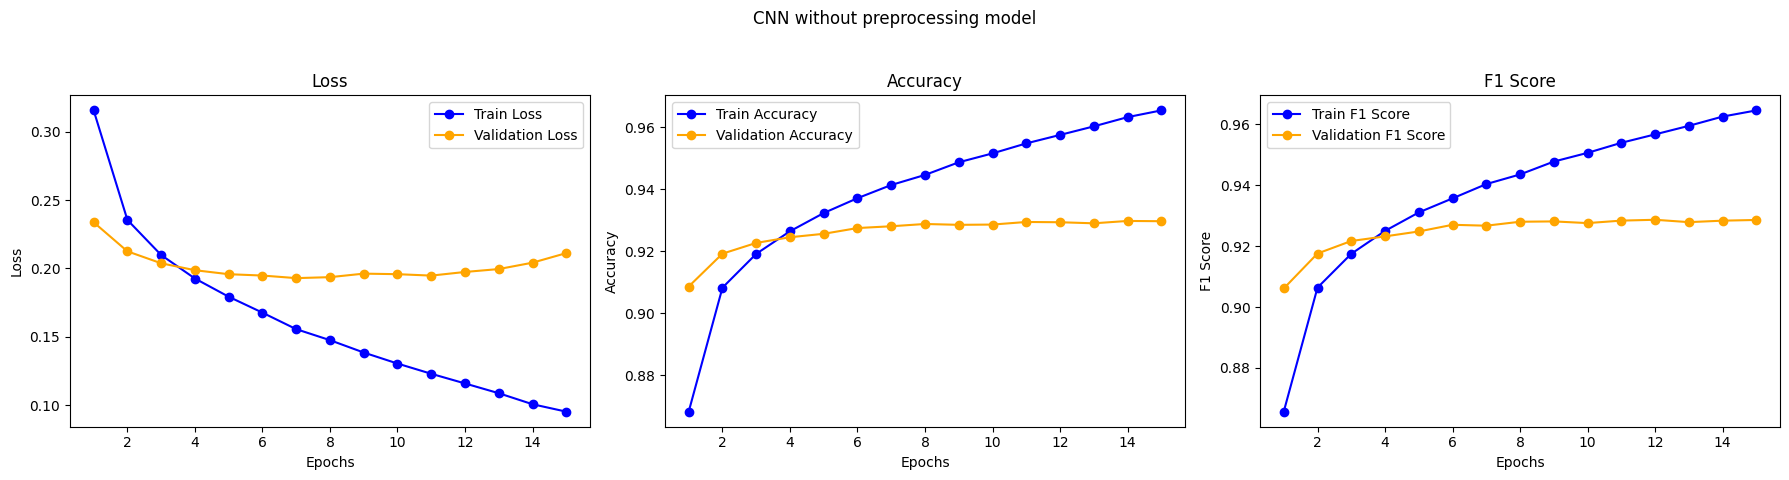

In [8]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with CBOW

Epoch [1/15], Train Loss: 0.4691, Val Loss: 0.4389, Train Accuracy: 0.7937%, Val Accuracy: 0.8057%, Train F1-Score: 0.7869%, Val F1-Score: 0.7950%
Epoch [2/15], Train Loss: 0.4439, Val Loss: 0.4366, Train Accuracy: 0.8024%, Val Accuracy: 0.8059%, Train F1-Score: 0.7914%, Val F1-Score: 0.7956%
Epoch [3/15], Train Loss: 0.4414, Val Loss: 0.4373, Train Accuracy: 0.8041%, Val Accuracy: 0.8053%, Train F1-Score: 0.7930%, Val F1-Score: 0.8007%
Epoch [4/15], Train Loss: 0.4397, Val Loss: 0.4328, Train Accuracy: 0.8044%, Val Accuracy: 0.8081%, Train F1-Score: 0.7932%, Val F1-Score: 0.7977%
Epoch [5/15], Train Loss: 0.4363, Val Loss: 0.4297, Train Accuracy: 0.8066%, Val Accuracy: 0.8092%, Train F1-Score: 0.7954%, Val F1-Score: 0.7972%
Epoch [6/15], Train Loss: 0.4324, Val Loss: 0.4246, Train Accuracy: 0.8086%, Val Accuracy: 0.8120%, Train F1-Score: 0.7978%, Val F1-Score: 0.8007%
Epoch [7/15], Train Loss: 0.4269, Val Loss: 0.4193, Train Accuracy: 0.8111%, Val Accuracy: 0.8152%, Train F1-Score: 0.

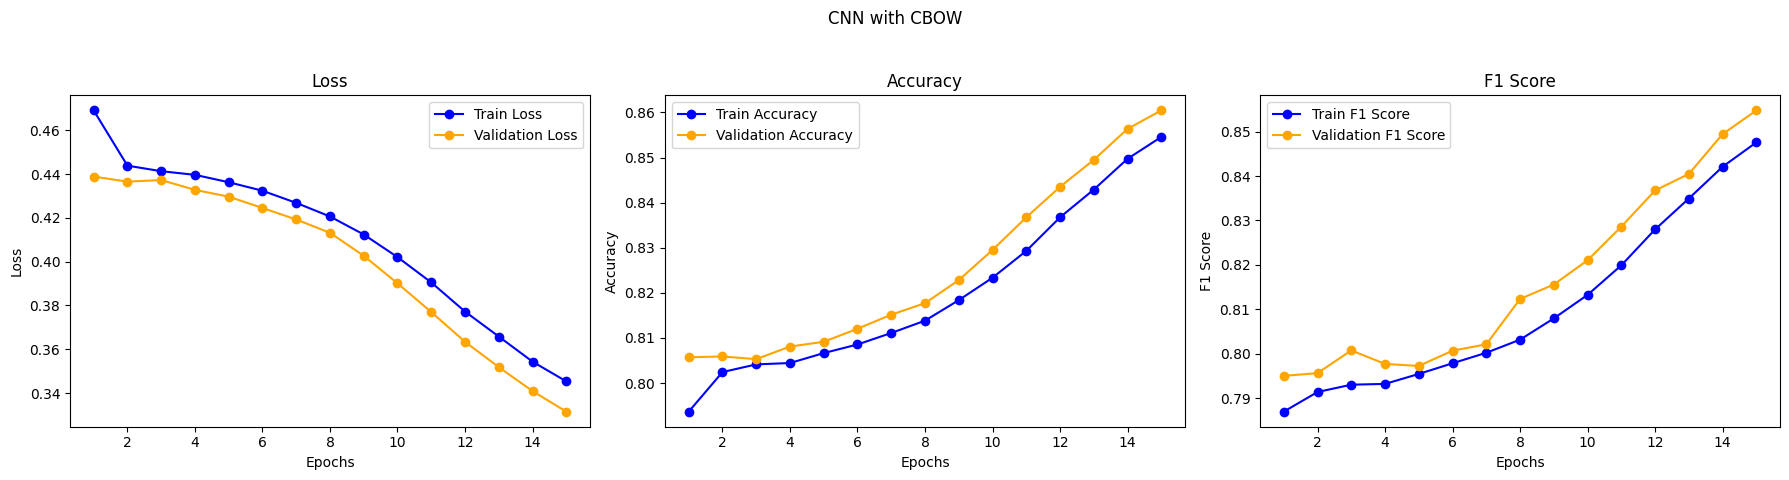

In [9]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with SkipGram

Epoch [1/15], Train Loss: 0.4460, Val Loss: 0.4073, Train Accuracy: 0.8006%, Val Accuracy: 0.8233%, Train F1-Score: 0.7929%, Val F1-Score: 0.8165%
Epoch [2/15], Train Loss: 0.3994, Val Loss: 0.3736, Train Accuracy: 0.8262%, Val Accuracy: 0.8404%, Train F1-Score: 0.8187%, Val F1-Score: 0.8374%
Epoch [3/15], Train Loss: 0.3683, Val Loss: 0.3450, Train Accuracy: 0.8428%, Val Accuracy: 0.8565%, Train F1-Score: 0.8367%, Val F1-Score: 0.8487%
Epoch [4/15], Train Loss: 0.3451, Val Loss: 0.3272, Train Accuracy: 0.8553%, Val Accuracy: 0.8641%, Train F1-Score: 0.8500%, Val F1-Score: 0.8615%
Epoch [5/15], Train Loss: 0.3283, Val Loss: 0.3146, Train Accuracy: 0.8629%, Val Accuracy: 0.8693%, Train F1-Score: 0.8580%, Val F1-Score: 0.8625%
Epoch [6/15], Train Loss: 0.3169, Val Loss: 0.3032, Train Accuracy: 0.8690%, Val Accuracy: 0.8752%, Train F1-Score: 0.8646%, Val F1-Score: 0.8714%
Epoch [7/15], Train Loss: 0.3066, Val Loss: 0.2951, Train Accuracy: 0.8740%, Val Accuracy: 0.8795%, Train F1-Score: 0.

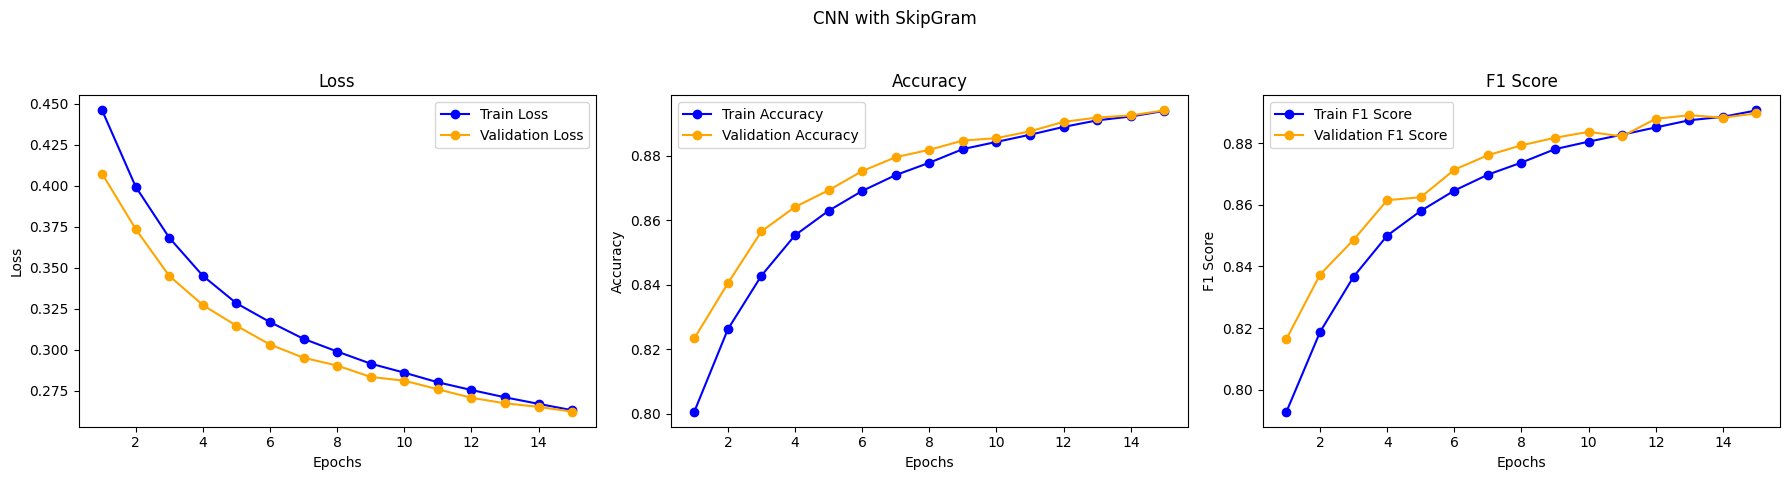

In [10]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with pretrained W2V in Gensim

Epoch [1/15], Train Loss: 0.3259, Val Loss: 0.2431, Train Accuracy: 0.8637%, Val Accuracy: 0.9056%, Train F1-Score: 0.8633%, Val F1-Score: 0.9035%
Epoch [2/15], Train Loss: 0.2449, Val Loss: 0.2242, Train Accuracy: 0.9041%, Val Accuracy: 0.9133%, Train F1-Score: 0.9017%, Val F1-Score: 0.9125%
Epoch [3/15], Train Loss: 0.2226, Val Loss: 0.2135, Train Accuracy: 0.9139%, Val Accuracy: 0.9176%, Train F1-Score: 0.9118%, Val F1-Score: 0.9159%
Epoch [4/15], Train Loss: 0.2074, Val Loss: 0.2084, Train Accuracy: 0.9200%, Val Accuracy: 0.9201%, Train F1-Score: 0.9184%, Val F1-Score: 0.9192%
Epoch [5/15], Train Loss: 0.1955, Val Loss: 0.2033, Train Accuracy: 0.9254%, Val Accuracy: 0.9218%, Train F1-Score: 0.9237%, Val F1-Score: 0.9201%
Epoch [6/15], Train Loss: 0.1859, Val Loss: 0.2013, Train Accuracy: 0.9288%, Val Accuracy: 0.9236%, Train F1-Score: 0.9274%, Val F1-Score: 0.9226%
Epoch [7/15], Train Loss: 0.1768, Val Loss: 0.2009, Train Accuracy: 0.9327%, Val Accuracy: 0.9244%, Train F1-Score: 0.

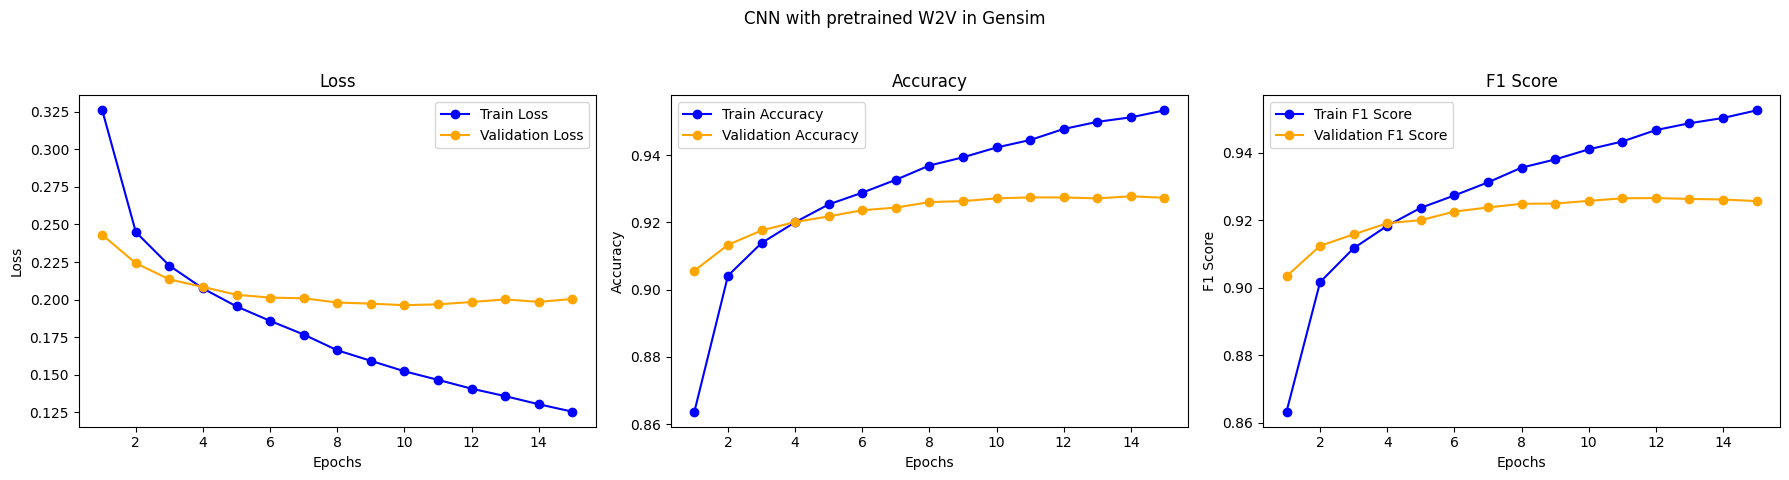

In [11]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)